In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler

In [3]:
###mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Read the stock price data

In [4]:
stock_df= pd.read_csv('./drive/My Drive/Colab Notebooks/GME_stock.csv',parse_dates=["date"])

In [5]:
stock_df.tail()

,date,open_price,high_price,low_price,close_price,volume,adjclose_price
4768,2002-02-20,9.600,9.875,9.525,9.875,1723200.0,6.648838
4769,2002-02-19,9.900,9.900,9.375,9.550,1852600.0,6.430017
4770,2002-02-15,10.000,10.025,9.850,9.950,2097400.0,6.699336
4771,2002-02-14,10.175,10.195,9.925,10.000,2755400.0,6.733003
4772,2002-02-13,9.625,10.060,9.525,10.050,19054000.0,6.766666


In [6]:
stock_df.head()

,date,open_price,high_price,low_price,close_price,volume,adjclose_price
0,2021-01-28,265.000000,483.000000,112.250000,193.600006,58815800.0,193.600006
1,2021-01-27,354.829987,380.000000,249.000000,347.510010,93396700.0,347.510010
2,2021-01-26,88.559998,150.000000,80.199997,147.979996,178588000.0,147.979996
3,2021-01-25,96.730003,159.179993,61.130001,76.790001,177874000.0,76.790001
4,2021-01-22,42.590000,76.760002,42.320000,65.010002,196784300.0,65.010002


The data has inverted order by date. We need to change it in  date ascending order.

In [7]:
stock_df=stock_df.sort_values(by="date", ascending=True)

In [8]:
stock_df.head()

,date,open_price,high_price,low_price,close_price,volume,adjclose_price
4772,2002-02-13,9.625,10.060,9.525,10.050,19054000.0,6.766666
4771,2002-02-14,10.175,10.195,9.925,10.000,2755400.0,6.733003
4770,2002-02-15,10.000,10.025,9.850,9.950,2097400.0,6.699336
4769,2002-02-19,9.900,9.900,9.375,9.550,1852600.0,6.430017
4768,2002-02-20,9.600,9.875,9.525,9.875,1723200.0,6.648838


Based on what I have learned in CPSC330 as below, the stock price prediction shoulbe be a lag_based features. Because in stock market analysis,we always use historical data to predict next week or next day prices.
I'll try lag=5 first and target take the tomorrow's close_price

**Lag-based features**
> Currently we're using features about today to predict tomorrow's rainfall.

> But, what if tomorrow's rainfall is also related to yesterday's features, or the day before?
> This is called a lagged feature.

In [9]:
def create_lag_feature(df,orig_feature,lag):
  new_df=df.copy()
  new_feature_name= "%s_lag%d" %(orig_feature, lag)
  new_df[new_feature_name]=np.nan
  new_df.loc[df.index[lag:],new_feature_name]=df.iloc[:-lag][orig_feature].values
  return new_df

In [10]:
def create_after_days_target(df,orig_column,days_after):
  new_df= df.copy()
  target_column='%s_after_%d_days'%(orig_column, days_after)
  if days_after==1:
    target_column=orig_column +"_tomorrow"
  new_df[target_column]=np.nan
  new_df.loc[df.index[:-days_after],target_column]=df.iloc[days_after:][orig_column].values
  return new_df

In [11]:
stock_df=create_lag_feature(stock_df,'close_price',1) ## add feture: yesterday close_price

In [12]:
stock_df=create_lag_feature(stock_df,'close_price',2) ## add feture: close_price of 2 days before 

In [13]:
stock_df=create_lag_feature(stock_df,'close_price',3)  ## add feture: close_price of 3 days before 

In [14]:
## create target column "close_price_tomorrow"
stock_df=create_after_days_target(stock_df,'close_price',1)

In [15]:
stock_df.head()

,date,open_price,high_price,low_price,close_price,volume,adjclose_price,close_price_lag1,close_price_lag2,close_price_lag3,close_price_tomorrow
4772,2002-02-13,9.625,10.060,9.525,10.050,19054000.0,6.766666,NaN,NaN,NaN,10.000
4771,2002-02-14,10.175,10.195,9.925,10.000,2755400.0,6.733003,10.05,NaN,NaN,9.950
4770,2002-02-15,10.000,10.025,9.850,9.950,2097400.0,6.699336,10.00,10.05,NaN,9.550
4769,2002-02-19,9.900,9.900,9.375,9.550,1852600.0,6.430017,9.95,10.00,10.05,9.875
4768,2002-02-20,9.600,9.875,9.525,9.875,1723200.0,6.648838,9.55,9.95,10.00,9.850


In [16]:
stock_df.tail()

,date,open_price,high_price,low_price,close_price,volume,adjclose_price,close_price_lag1,close_price_lag2,close_price_lag3,close_price_tomorrow
4,2021-01-22,42.590000,76.760002,42.320000,65.010002,196784300.0,65.010002,43.029999,39.119999,39.360001,76.790001
3,2021-01-25,96.730003,159.179993,61.130001,76.790001,177874000.0,76.790001,65.010002,43.029999,39.119999,147.979996
2,2021-01-26,88.559998,150.000000,80.199997,147.979996,178588000.0,147.979996,76.790001,65.010002,43.029999,347.510010
1,2021-01-27,354.829987,380.000000,249.000000,347.510010,93396700.0,347.510010,147.979996,76.790001,65.010002,193.600006
0,2021-01-28,265.000000,483.000000,112.250000,193.600006,58815800.0,193.600006,347.510010,147.979996,76.790001,NaN


Split the dataframe into training set and test set


> there are some NaN values when we create new features and target columns. one way is to delete these column. the other way is to use SimpleImputer.
<br> lets just delete them first
<br> TODO, add SimpleImputer in preprocessing pipeline.



In [17]:
training_data = stock_df[3:3773]  # from index 0 to 3772, NOT 3773  ### not include the first 3 row
test_data = stock_df[3773:4772]   # from index 3773 to 4772         ### not include the last row

In [18]:
training_data.head()

,date,open_price,high_price,low_price,close_price,volume,adjclose_price,close_price_lag1,close_price_lag2,close_price_lag3,close_price_tomorrow
4769,2002-02-19,9.900,9.900,9.375,9.550,1852600.0,6.430017,9.950,10.000,10.050,9.875
4768,2002-02-20,9.600,9.875,9.525,9.875,1723200.0,6.648838,9.550,9.950,10.000,9.850
4767,2002-02-21,9.840,9.925,9.750,9.850,1744200.0,6.632006,9.875,9.550,9.950,9.675
4766,2002-02-22,9.925,9.925,9.600,9.675,881400.0,6.514178,9.850,9.875,9.550,9.750
4765,2002-02-25,9.650,9.825,9.540,9.750,863400.0,6.564678,9.675,9.850,9.875,9.750


In [19]:
training_data.tail()

,date,open_price,high_price,low_price,close_price,volume,adjclose_price,close_price_lag1,close_price_lag2,close_price_lag3,close_price_tomorrow
1004,2017-02-01,24.490000,24.639999,24.080000,24.299999,1752900.0,19.761581,24.490000,24.180000,24.309999,24.379999
1003,2017-02-02,24.389999,24.580000,24.270000,24.379999,1651800.0,19.826637,24.299999,24.490000,24.180000,24.740000
1002,2017-02-03,24.350000,24.900000,24.280001,24.740000,2242700.0,20.119406,24.379999,24.299999,24.490000,24.680000
1001,2017-02-06,24.740000,24.950001,24.520000,24.680000,1704600.0,20.070614,24.740000,24.379999,24.299999,24.629999
1000,2017-02-07,24.700001,25.000000,24.510000,24.629999,2179600.0,20.029951,24.680000,24.740000,24.379999,24.790001


In [20]:
X_train = training_data.drop(columns=['close_price_tomorrow','date'])  #revision1: 先把date给drop掉 TODO：transform date to a day_since value
y_train =training_data[['close_price_tomorrow']]

In [21]:
y_train

,close_price_tomorrow
4769,9.875000
4768,9.850000
4767,9.675000
4766,9.750000
4765,9.750000
...,...
1004,24.379999
1003,24.740000
1002,24.680000
1001,24.629999


In [22]:
X_test = test_data.drop(columns=['close_price_tomorrow','date'])
y_test = test_data[['close_price_tomorrow']]

In [23]:
y_test.tail()

,close_price_tomorrow
5,65.010002
4,76.790001
3,147.979996
2,347.510010
1,193.600006


MinMaxScaler on both training and test data:

In [24]:
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

X_train_scaled= x_train_scaler.fit_transform(X_train)
y_train_scaled= y_train_scaler.fit_transform(y_train)

X_test_scaled= x_test_scaler.fit_transform(X_test)
y_test_scaled= y_test_scaler.fit_transform(y_test)

In [25]:
X_train_scaled.shape

(3770, 9)

Build the BPNN model

In [27]:
model=Sequential()  
model.add(Dense(16,input_dim=9,kernel_initializer='uniform',activation='relu'))
model.add(Dense(4,kernel_initializer='uniform',activation='relu')) #中间层
model.add(Dense(1,activation='linear'))  ##输出层
model.compile(loss='mean_squared_error',optimizer=keras.optimizers.Adam(lr=0.01),metrics = ['mse', 'mae']) #编译模型
model.fit(X_train_scaled,
          y_train_scaled,
          epochs=200,
          batch_size=256,
          validation_data=(X_test_scaled,y_test_scaled))

# model.fit(X_train,
#           y_train,
#           epochs=50,
#           batch_size=256,
#           validation_data=(X_test_scaled,Y_test_scaled))

Epoch 1/200
15/15 [==============================] - 1s 20ms/step - loss: 0.1166 - mse: 0.1166 - mae: 0.2693 - val_loss: 0.0806 - val_mse: 0.0806 - val_mae: 0.2837
Epoch 2/200
15/15 [==============================] - 0s 5ms/step - loss: 0.0195 - mse: 0.0195 - mae: 0.1179 - val_loss: 0.0340 - val_mse: 0.0340 - val_mae: 0.1836
Epoch 3/200
15/15 [==============================] - 0s 4ms/step - loss: 0.0069 - mse: 0.0069 - mae: 0.0712 - val_loss: 0.0074 - val_mse: 0.0074 - val_mae: 0.0833
Epoch 4/200
15/15 [==============================] - 0s 4ms/step - loss: 9.6579e-04 - mse: 9.6579e-04 - mae: 0.0241 - val_loss: 0.0021 - val_mse: 0.0021 - val_mae: 0.0391
Epoch 5/200
15/15 [==============================] - 0s 4ms/step - loss: 3.9430e-04 - mse: 3.9430e-04 - mae: 0.0155 - val_loss: 0.0020 - val_mse: 0.0020 - val_mae: 0.0372
Epoch 6/200
15/15 [==============================] - 0s 4ms/step - loss: 3.2126e-04 - mse: 3.2126e-04 - mae: 0.0134 - val_loss: 0.0028 - val_mse: 0.0028 - val_mae: 0.04

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                160       
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 68        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 233
Trainable params: 233
Non-trainable params: 0
_________________________________________________________________


In [29]:
y_train_predict=model.predict(X_train_scaled)

Use scaler.inverse_transform to convert scaled y value to true price value

In [30]:
y_pred_train=y_train_scaler.inverse_transform(y_train_predict)
y_actual_train=y_train_scaler.inverse_transform(y_train_scaled)

In [31]:
true_predict_train=pd.concat([pd.DataFrame(y_actual_train),pd.DataFrame(y_pred_train)],axis=1)
true_predict_train.columns=['y_actual_train','y_pred_train']
true_predict_train

,y_actual_train,y_pred_train
0,9.875000,9.220109
1,9.850000,9.408079
2,9.675000,9.467639
3,9.750000,9.343623
4,9.750000,9.341774
...,...,...
3765,24.379999,23.704681
3766,24.740000,23.769789
3767,24.680000,24.031782
3768,24.629999,24.074646


Text(0.5, 1.0, 'Train Data')

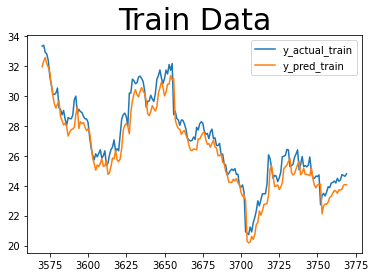

In [32]:
true_predict_train.iloc[-200:,:].plot()
plt.title('Train Data',fontsize='30')

As above,seems overfit

> Then, predict test data

In [33]:
y_test_predict=model.predict(X_test_scaled)
y_pred_test=y_test_scaler.inverse_transform(y_test_predict)
y_actual_test=y_test_scaler.inverse_transform(y_test_scaled)

In [34]:
true_predict_test=pd.concat([pd.DataFrame(y_actual_test),pd.DataFrame(y_pred_test)],axis=1)
true_predict_test.columns=['y_actual_test','y_pred_test']
true_predict_test

,y_actual_test,y_pred_test
0,25.389999,25.006643
1,25.660000,25.455439
2,25.370001,25.834095
3,25.740000,25.737995
4,25.780001,25.912561
...,...,...
994,65.010002,41.663986
995,76.790001,60.708626
996,147.979996,90.953850
997,347.510010,130.622726


Text(0.5, 1.0, 'Test Data')

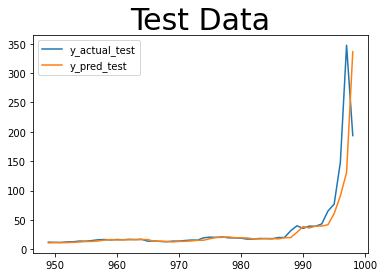

In [35]:
true_predict_test.iloc[-50:,:].plot()
plt.title('Test Data',fontsize='30')

In [36]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math
def mape(y_pred,y_true):
    return np.mean(np.abs((y_pred-y_true)/y_true))*100
print('Training data: MAE/MSE/MAPE')
print(mean_absolute_error(y_pred_train, y_actual_train))
print(mean_squared_error(y_pred_train, y_actual_train) )
print(mape(y_pred_train, y_actual_train) )
print('Test data: MAE/MSE/MAPE')
print(mean_absolute_error(y_pred_test, y_actual_test))
print(mean_squared_error(y_pred_test, y_actual_test))
print(mape(y_pred_test, y_actual_test) )

Training data: MAE/MSE/MAPE
0.8528065316556935
1.2528235439742923
3.5219478313520973
Test data: MAE/MSE/MAPE
1.0853000290997632
72.59355013025112
9.40758248587283


确实overfitting.


TODO2: to understand keras.optimizer.sgd 随机梯度下降的用法； 找到比较好的model设置。

<br>从数值上粗略判断 当天的close_price对明天的预测结果影响较大！

In [37]:
y_var_test=y_actual_test[1:]-y_actual_test[:len(y_actual_test)-1]
y_var_predict=y_pred_test[1:]-y_pred_test[:len(y_pred_test)-1]
txt=np.zeros(len(y_var_test))
for i in range(len(y_var_test)-1):
    txt[i]=np.sign(y_var_test[i])==np.sign(y_var_predict[i])
result=sum(txt)/len(txt)
print('预测涨跌正确:',result)

预测涨跌正确: 0.3687374749498998


In [38]:
def convert2matrix(data_arr, look_back):
 X, Y =[], []
 for i in range(len(data_arr)-look_back):
  d=i+look_back  
  X.append(data_arr[i:d,0])
  Y.append(data_arr[d,0])
 return np.array(X), np.array(Y)

In [81]:
df=stock_df['close_price']

In [82]:
arr_train = np.array(df_train).reshape(-1,1)
# test=[10.05000019, 10.        ,  9.94999981,  9.55000019,  9.875     ,
#         9.85000038,  9.67500019,  9.75      ,  9.75      ,  9.57499981]
# test=np.array(test).reshape(-1,1)  ###非常有用！

In [83]:
X,Y= convert2matrix(arr_train, 30)

In [84]:
test_df=pd.concat([pd.DataFrame(X),pd.DataFrame(Y)],axis=1)

In [85]:
test_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,0
0,9.550000,9.875000,9.850000,9.675000,9.750000,9.750000,9.575000,9.550000,9.685000,9.850000,9.625000,9.675000,10.210000,10.450000,10.585000,10.600000,10.510000,10.500000,10.175000,9.650000,9.350000,9.010000,9.375000,9.650000,9.860000,9.990000,10.300000,10.100000,9.525000,9.320000,9.300000
1,9.875000,9.850000,9.675000,9.750000,9.750000,9.575000,9.550000,9.685000,9.850000,9.625000,9.675000,10.210000,10.450000,10.585000,10.600000,10.510000,10.500000,10.175000,9.650000,9.350000,9.010000,9.375000,9.650000,9.860000,9.990000,10.300000,10.100000,9.525000,9.320000,9.300000,9.475000
2,9.850000,9.675000,9.750000,9.750000,9.575000,9.550000,9.685000,9.850000,9.625000,9.675000,10.210000,10.450000,10.585000,10.600000,10.510000,10.500000,10.175000,9.650000,9.350000,9.010000,9.375000,9.650000,9.860000,9.990000,10.300000,10.100000,9.525000,9.320000,9.300000,9.475000,9.245000
3,9.675000,9.750000,9.750000,9.575000,9.550000,9.685000,9.850000,9.625000,9.675000,10.210000,10.450000,10.585000,10.600000,10.510000,10.500000,10.175000,9.650000,9.350000,9.010000,9.375000,9.650000,9.860000,9.990000,10.300000,10.100000,9.525000,9.320000,9.300000,9.475000,9.245000,9.150000
4,9.750000,9.750000,9.575000,9.550000,9.685000,9.850000,9.625000,9.675000,10.210000,10.450000,10.585000,10.600000,10.510000,10.500000,10.175000,9.650000,9.350000,9.010000,9.375000,9.650000,9.860000,9.990000,10.300000,10.100000,9.525000,9.320000,9.300000,9.475000,9.245000,9.150000,9.475000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3735,25.420000,25.900000,26.120001,26.389999,25.059999,25.410000,25.950001,25.270000,25.340000,25.260000,25.370001,25.920000,25.000000,24.520000,24.490000,24.639999,24.610001,24.719999,22.730000,23.340000,23.490000,23.309999,23.580000,23.930000,23.870001,24.170000,24.219999,24.309999,24.180000,24.490000,24.299999
3736,25.900000,26.120001,26.389999,25.059999,25.410000,25.950001,25.270000,25.340000,25.260000,25.370001,25.920000,25.000000,24.520000,24.490000,24.639999,24.610001,24.719999,22.730000,23.340000,23.490000,23.309999,23.580000,23.930000,23.870001,24.170000,24.219999,24.309999,24.180000,24.490000,24.299999,24.379999
3737,26.120001,26.389999,25.059999,25.410000,25.950001,25.270000,25.340000,25.260000,25.370001,25.920000,25.000000,24.520000,24.490000,24.639999,24.610001,24.719999,22.730000,23.340000,23.490000,23.309999,23.580000,23.930000,23.870001,24.170000,24.219999,24.309999,24.180000,24.490000,24.299999,24.379999,24.740000
3738,26.389999,25.059999,25.410000,25.950001,25.270000,25.340000,25.260000,25.370001,25.920000,25.000000,24.520000,24.490000,24.639999,24.610001,24.719999,22.730000,23.340000,23.490000,23.309999,23.580000,23.930000,23.870001,24.170000,24.219999,24.309999,24.180000,24.490000,24.299999,24.379999,24.740000,24.680000


In [87]:
train_size=2992
train,test=test_df[0:train_size],test_df[train_size:]

In [88]:
train.shape

(2992, 31)

In [89]:
test.shape

(748, 31)

In [96]:
trainX=train.iloc[:,:-1]
trainY=train.iloc[:,-1:]
testX=test.iloc[:,:-1]
testY=test.iloc[:,-1:]

In [95]:
from keras.models import Sequential
from keras.layers import Dense
def model_dnn(look_back):
  model=Sequential()
  model.add(Dense(units=32,input_dim=look_back,activation='relu'))
  model.add(Dense(8,activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mse','mae'])
  return model

In [99]:
model=model_dnn(30)
history=model.fit(trainX,trainY,
                  epochs=100,
                  batch_size=30,
                  verbose=1,
                  validation_data=(testX,testY),
                  shuffle=False)

Epoch 1/100
100/100 [==============================] - 1s 5ms/step - loss: 4.5371 - mse: 4.5371 - mae: 1.4964 - val_loss: 22.0055 - val_mse: 22.0055 - val_mae: 4.1957
Epoch 2/100
100/100 [==============================] - 0s 2ms/step - loss: 4.6509 - mse: 4.6509 - mae: 1.6883 - val_loss: 15.5386 - val_mse: 15.5386 - val_mae: 3.4715
Epoch 3/100
100/100 [==============================] - 0s 2ms/step - loss: 3.4100 - mse: 3.4100 - mae: 1.3895 - val_loss: 13.5846 - val_mse: 13.5846 - val_mae: 3.2345
Epoch 4/100
100/100 [==============================] - 0s 2ms/step - loss: 2.7102 - mse: 2.7102 - mae: 1.1771 - val_loss: 12.1712 - val_mse: 12.1712 - val_mae: 3.0539
Epoch 5/100
100/100 [==============================] - 0s 2ms/step - loss: 2.3313 - mse: 2.3313 - mae: 1.0565 - val_loss: 9.5517 - val_mse: 9.5517 - val_mae: 2.6606
Epoch 6/100
100/100 [==============================] - 0s 2ms/step - loss: 1.9918 - mse: 1.9918 - mae: 0.9202 - val_loss: 7.9597 - val_mse: 7.9597 - val_mae: 2.3962
Ep

In [100]:
def model_loss(history):
  plt.figure(figsize=(8,4))
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Test Loss')
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend(loc='upper right')
  plt.show();


Train Root Mean Squared Error(RMSE): 1.72; Train Mean Absolute Error(MAE) : 1.54 
Test Root Mean Squared Error(RMSE): 1.46; Test Mean Absolute Error(MAE) : 1.16 


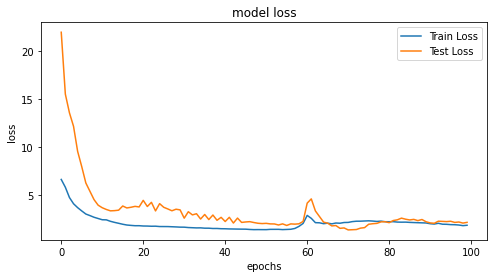

In [101]:
train_score = model.evaluate(trainX, trainY, verbose=0)  ##model.evaluate要用起来！
print('Train Root Mean Squared Error(RMSE): %.2f; Train Mean Absolute Error(MAE) : %.2f ' 
% (np.sqrt(train_score[1]), train_score[2]))  ###这里用了np.sqrt()
test_score = model.evaluate(testX, testY, verbose=0)
print('Test Root Mean Squared Error(RMSE): %.2f; Test Mean Absolute Error(MAE) : %.2f ' 
% (np.sqrt(test_score[1]), test_score[2]))
model_loss(history)

In [111]:
def prediction_plot(testY,test_predict):
  len_prediction=[x for x in range(len(testY))]
  plt.figure(figsize=(8,4))
  plt.plot(len_prediction[-200:],testY[-200:],marker='.',label='actual')
  plt.plot(len_prediction[-200:], test_predict[-200:],'r',label='prediction')
  plt.tight_layout()
  sns.despine(top=True)
  plt.subplots_adjust(left=0.07)
  plt.ylabel('stock_price',size=15)
  plt.xlabel('Time step',size=15)
  plt.legend(fontsize=15)
  plt.title('Prediction VS Actual Stock Price after 30 days_Test data')
  plt.show()

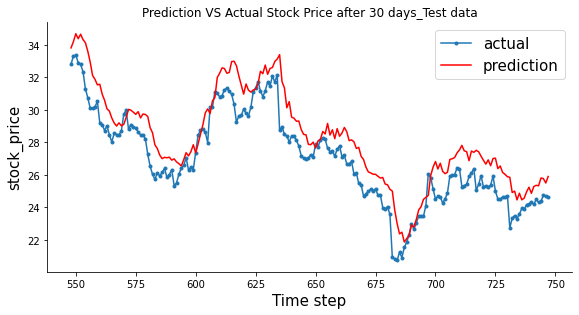

In [112]:
test_predict=model.predict(testX)
prediction_plot(testY,test_predict)

In [124]:
testY= np.array(testY).reshape(-1,1)
y_var_test=testY[1:]-testY[:len(testY)-1]
y_var_predict=test_predict[1:]-test_predict[:len(test_predict)-1]
txt=np.zeros(len(y_var_test))
for i in range(len(y_var_test)-1):
    txt[i]=np.sign(y_var_test[i])==np.sign(y_var_predict[i])
result=sum(txt)/len(txt)
print('预测涨跌正确:',result)


预测涨跌正确: 0.48460508701472554


**Use RNN(Recurrent Neural Network) model**

In [134]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.callbacks import EarlyStopping
def model_rnn(look_back):
  model=Sequential()
  model.add(SimpleRNN(units=32,input_shape=(1,look_back),activation='relu'))
  model.add(Dense(8,activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mse','mae'])
  return model

In [135]:
model=model_rnn(30)

In [130]:
trainX.shape

(2992, 30)

In [131]:
trainY

,0
0,9.300000
1,9.475000
2,9.245000
3,9.150000
4,9.475000
...,...
2987,36.509998
2988,35.860001
2989,35.610001
2990,36.139999


In [136]:
history=model.fit(trainX,trainY,
                  epochs=100,
                  batch_size=30,
                  verbose=1,
                  validation_data=(testX,testY),
                  callbacks=[EarlyStopping(monitor='val_loss', patience=10)],shuffle=False)

Epoch 1/100


ValueError: ignored